# **ResNet50 for Knee X-Ray Classification**

In this notebook, we develop and train a ResNet50 model for binary classification of knee X-ray images. The images are categorized into two classes: grades KL0 and KL1 are grouped into one class, and grades KL2, KL3, and KL4 are grouped into another class to evaluate the severity of knee osteoarthritis.

We use a [dataset](https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity) from Kaggle, which provides a collection of knee X-ray images. The notebook will cover the data preprocessing steps, model training, and evaluation processes to assess the performance of the ResNet50 model. Additionally, we will analyze the results to understand how well the model distinguishes between different grades of osteoarthritis.

## **Data Pre-processing**



Data preprocessing is essential for preparing raw data for analysis and model training. It involves cleaning, transforming, and organizing the data to enhance model performance. Below, we detail all the preprocessing steps performed.

### **Importing Essential Libraries**




Initially, we import all the necessary libraries used throughout the notebook for analysis and model training.

In [28]:
import glob
import os
import cv2
import timeit
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from operator import itemgetter
import tensorflow as tf

!pip install kaggle > /dev/null

### **Utility Functions**

We define several utility functions to facilitate data processing and model training. These functions help automate repetitive tasks and ensure code consistency throughout the notebook.

In [2]:
def selectRandomImgs(side):
  selected_imgs = []

  # Given the side (L or R), find an image for each grade.
  for grades in range(5):
    images = glob.glob(f"/content/KneeKL224/train/{grades}/*.png")
    filtered_imgs = [i for i in images if side in os.path.basename(i)]
    random_img = random.choice(filtered_imgs)
    selected_imgs.append(random_img)

  return selected_imgs

def countImagesByGrade(path):
  cont = [0]*5

  # Calculate the number of photos for each grade.
  for grades in range(5):
    cont[grades] = len(glob.glob(path + f'{grades}/*.png'))

  return cont

def countImagesByClass(path):
    class_counts = {'Negative': 0, 'Positive': 0}

    # Calculate the number of images in each class.
    class_counts['Negative'] = len(glob.glob(path + 'Negative/*.png'))
    class_counts['Positive'] = len(glob.glob(path + 'Positive/*.png'))

    return class_counts

def moveImgs(images, grade, path_dst):
  img_paths = glob.glob(f'/content/DatasetKneeKL/{grade}/*.png')
  imgs = itemgetter(*images)(img_paths)
  for img in imgs:
    #print(f'Copio {img} in {path_dst}')
    shutil.move(img, path_dst)

def drawHist(class_counts):
    plt.bar(['Negative', 'Positive'], class_counts.values())
    plt.title('Number of Images per Class')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

### **Downloading the dataset**

We download the dataset directly from Kaggle. This step involves using Kaggle’s API to download the dataset locally.

In [3]:
# Dataset download (https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity)
!kaggle datasets download -d shashwatwork/knee-osteoarthritis-dataset-with-severity

!mkdir -p KneeKL224
!unzip knee-osteoarthritis-dataset-with-severity.zip -d KneeKL224 > /dev/null

!rm knee-osteoarthritis-dataset-with-severity.zip

Dataset URL: https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity
License(s): Attribution 4.0 International (CC BY 4.0)
 98% 199M/204M [00:03<00:00, 50.7MB/s]
100% 204M/204M [00:03<00:00, 64.9MB/s]


### **Dataset structure**

We examine the structure of the dataset to understand its organization and contents.

The dataset contains knee X-ray images organized by the five grades of the Kellgren-Lawrence (KL) scale. elow, a visual comparison of the five KL grades is provided.

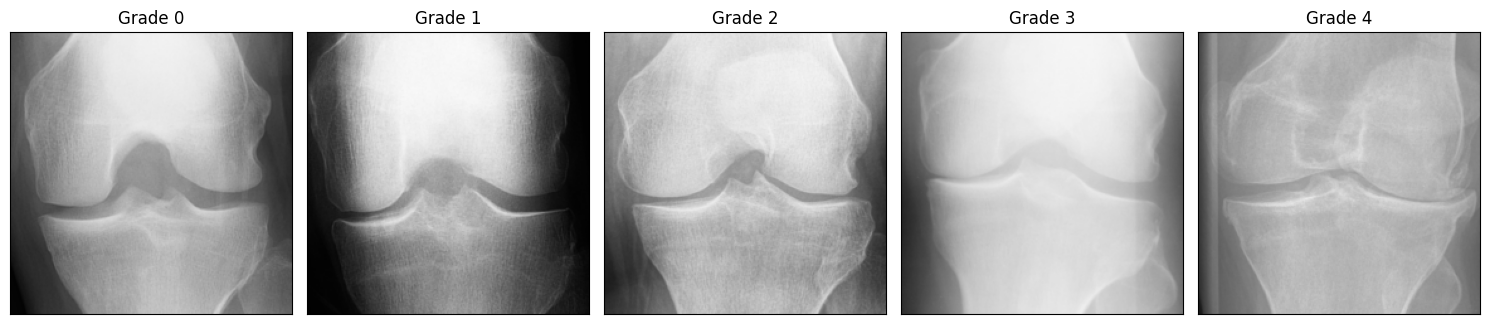

In [11]:
# Parameter for the 'side' of the knee. Possible values: L = Left | R = Right
side = 'L'

# Select 5 random images of the chosen side
selected_imgs = selectRandomImgs(side)
images = [cv2.imread(path) for path in selected_imgs]

# Create the layout to display the images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 12))
for i in range(5):
  axes[i].imshow(images[i])
  axes[i].set_title(f'Grade {i}')

# Remove axes
for ax in axes.flat:
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

Initially, the dataset contained four folders: training, test, validation, and auto_test. The *auto_test* folder included a modified version of the test images and has been removed.

In [4]:
!ls /content/KneeKL224

auto_test  test  train	val


In [5]:
shutil.rmtree('/content/KneeKL224/auto_test')

 Each of these folders contains images categorized into the five Kellgren-Lawrence (KL) grades. There are no explicit labels provided. The grade of each image is inferred from the folder name in which the image is located.

The following code reorganizes the dataset by moving the images into a new directory structure based on their Kellgren-Lawrence grade.

In [6]:
# Creation of the main folder for the new dataset and the corresponding subfolders
os.makedirs('DatasetKneeKL', exist_ok=True)
_ = [os.makedirs(f'DatasetKneeKL/{n}', exist_ok=True) for n in range(5)]

# Moves PNG images from source directories to corresponding destination directories by grade
for grade in range(5):
  for dir in ['train', 'val', 'test']:
    path_src = f'/content/KneeKL224/{dir}/{grade}/*.png'
    path_dst = f'/content/DatasetKneeKL/{grade}/*.png'

    for img in glob.glob(path_src):
      dst_name = f'/content/DatasetKneeKL/{grade}/{os.path.basename(img)}'
      shutil.move(img, dst_name)

shutil.rmtree('/content/KneeKL224')

In [7]:
grades = countImagesByGrade('/content/DatasetKneeKL/')

print(f'Total dataset cardinality: {sum(grades)}')
_ = [print(f'   Images of grade {g}: {grades[g]}') for g in range(5)]

Total dataset cardinality: 8260
   Images of grade 0: 3253
   Images of grade 1: 1495
   Images of grade 2: 2175
   Images of grade 3: 1086
   Images of grade 4: 251


Below, we reorganize the dataset for binary classification by moving and renaming directories.

In [8]:
# Move images of grade 1 to the directory containing those of grade 0
moveImgs(range(len(glob.glob(f'/content/DatasetKneeKL/1/*.png'))), 1, f'/content/DatasetKneeKL/0')

# Move images of grades 3 and 4 to the directory containing those of grade 2
moveImgs(range(len(glob.glob(f'/content/DatasetKneeKL/3/*.png'))), 3, f'/content/DatasetKneeKL/2')
moveImgs(range(len(glob.glob(f'/content/DatasetKneeKL/4/*.png'))), 4, f'/content/DatasetKneeKL/2')

# Rename the directories to 'Negative' and 'Positive'
os.rename('/content/DatasetKneeKL/0', '/content/DatasetKneeKL/Negative')
os.rename('/content/DatasetKneeKL/2', '/content/DatasetKneeKL/Positive')

# Remove the now empty directories for grades 1, 3, and 4
shutil.rmtree('/content/DatasetKneeKL/1')
shutil.rmtree('/content/DatasetKneeKL/3')
shutil.rmtree('/content/DatasetKneeKL/4')

In [9]:
# Count the number of images in the 'Negative' and 'Positive' directories
class_counts = countImagesByClass('/content/DatasetKneeKL/')

print(f'Total dataset cardinality: {sum(class_counts.values())}')
print(f'   Negative images: {class_counts["Negative"]}')
print(f'   Positive images: {class_counts["Positive"]}')

Total dataset cardinality: 8260
   Negative images: 4748
   Positive images: 3512


The distribution of images across the two classes is visualized using a bar chart.

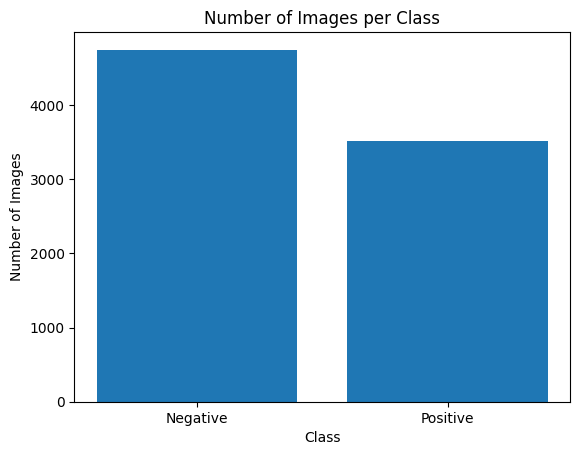

In [10]:
drawHist(class_counts)

### **Dataset Splitting: Train, Validation, and Test Sets**

In this section, the dataset is divided into training, validation, and test sets using functionalities provided by the *scikit-learn* library.

The dataset is split according to the following percentages:
- **Training Set**: 67.5% of the total dataset
- **Validation Set**: 22.5% of the total dataset
- **Test Set**: 10% of the total dataset


Initially, the folder structure for organizing the dataset is set up.

In [11]:
classes = ['Positive', 'Negative']
_ = [os.makedirs(f'DatasetKneeKL/{dir}/{cls}', exist_ok=True) for dir in ['train', 'val', 'test'] for cls in classes]

Indices are calculated for the initial division of the dataset into training/validation and test sets.

In [12]:
train_val_idx, test_idx = [0]*2, [0]*2
db_len = [len(glob.glob(f'/content/DatasetKneeKL/{x}/*.png')) for x in ['Positive', 'Negative']]

for i in range(2):
  train_val_idx[i], test_idx[i] = train_test_split(
      np.arange(db_len[i]), test_size=0.1, random_state=42, shuffle=True)

The distribution of images across training/validation and test sets is displayed for each Kellgren-Lawrence grade. Images are then moved to the appropriate test set directories based on the calculated indices.

In [13]:
_ = [print(f'Images {classes[i]:<8}: {db_len[i]:<8} | Training/Validation: {len(train_val_idx[i]):<8} | Test: {len(test_idx[i]):<8}') for i in range(2)]

for i, cls in enumerate(classes):
    moveImgs(test_idx[i], cls, f'/content/DatasetKneeKL/test/{cls}')

Images Positive: 3512     | Training/Validation: 3160     | Test: 352     
Images Negative: 4748     | Training/Validation: 4273     | Test: 475     


The indices for dividing the remaining images into training and validation sets are calculated.

In [14]:
train_idx, val_idx = [0]*2, [0]*2
db_len = [len(glob.glob(f'/content/DatasetKneeKL/{x}/*.png')) for x in ['Positive', 'Negative']]

for i in range(2):
  train_idx[i], val_idx[i] = train_test_split(
      np.arange(db_len[i]), test_size=0.25, random_state=42, shuffle=True)

As before, the cardinalities are displayed, and the images are moved to their respective directories. The original dataset directory is then removed.

In [15]:
# Print to verify the cardinalities
_ = [print(f'Images {classes[i]:<8}: {db_len[i]:<8} | Training: {len(train_idx[i]):<8} | Validation: {len(val_idx[i]):<8}') for i in range(2)]

# Move the training images to the corresponding training directories
for i, cls in enumerate(classes):
    moveImgs(train_idx[i], cls, f'/content/DatasetKneeKL/train/{cls}')

# Move the validation images to the corresponding validation directories
for i, cls in enumerate(classes):
    moveImgs(range(len(val_idx[i])), cls, f'/content/DatasetKneeKL/val/{cls}')


Images Positive: 3160     | Training: 2212     | Validation: 948     
Images Negative: 4273     | Training: 2991     | Validation: 1282    


In [16]:
shutil.rmtree('/content/DatasetKneeKL/Negative', ignore_errors=True)
shutil.rmtree('/content/DatasetKneeKL/Positive', ignore_errors=True)

### **Equalization**

The radiographic images in the dataset exhibited inherent limitations such as low contrast and imbalanced brightness. Histogram equalization was applied to enhance anatomical details and better highlight any potential osteoarthritis. This process used the `equalizeHist()` function from the OpenCV library after converting the images to grayscale.


Below is an example of the equalization applied to a training image.

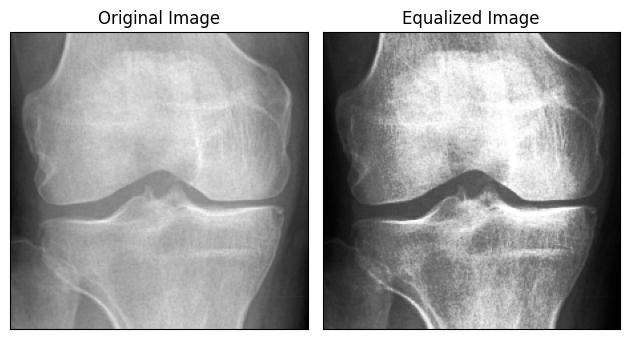

In [ ]:
im1 = cv2.imread("/content/DatasetKneeKL/train/2/9022902R.png", cv2.IMREAD_GRAYSCALE)
equalized_img = cv2.equalizeHist(im1)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(im1, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(equalized_img, cmap='gray')
axes[1].set_title('Equalized Image')

# Rimozione assi
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [17]:
def equalize_images(path):
    for cls in classes:
        for image_path in glob.glob(f'{path}/{cls}/*.png'):
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            equalized_image = cv2.equalizeHist(image)
            cv2.imwrite(image_path, equalized_image)

equalize_images('/content/DatasetKneeKL/train')
equalize_images('/content/DatasetKneeKL/val')
equalize_images('/content/DatasetKneeKL/test')

### **Data Augmentation**

In this section, the process of applying data augmentation is explained. This technique is used to increase the variability of the training data, helping to reduce overfitting and improve the model's generalization.

First of all, the directory paths for the training, validation, and test datasets are set up.

In [18]:
base_dir = "/content/DatasetKneeKL/"

train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

The `ImageDataGenerator` is used to apply various transformations such as horizontal flipping, brightness adjustments, width shifting, and zooming to the training set images.


In [19]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

Additionally, a separate `ImageDataGenerator` is set up without augmentation for the validation and test set, applying only the necessary preprocessing.

In [20]:
noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
)

Then, the data generators are set up.


In [22]:
target_size = (224, 224)

train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

test_generator = noaug_datagen.flow_from_directory(
    test_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 5203 images belonging to 2 classes.
Found 2230 images belonging to 2 classes.
Found 827 images belonging to 2 classes.


### **Class Weights**

In this section, class weights for the training dataset are computed to improve model performance.


In [23]:
from sklearn.utils.class_weight import compute_class_weight

y_train = train_generator.labels
y_val = valid_generator.labels

unique, counts = np.unique(y_train, return_counts=True)

# Compute class weights to balance the dataset
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)

train_class_weights = dict(enumerate(class_weights))

# Display the class weights
print(train_class_weights)

{0: 0.8697759946506185, 1: 1.1760849909584086}


## **Model Training**

In this section, a neural network model is configured and trained using TensorFlow and Keras. The model is based on a pre-trained ResNet50, with modifications made for the specific classification task.

First of all, the ResNet50 model pre-trained on ImageNet is loaded and configured for fine-tuning.

In [24]:
epochs = 100
batch_size = 32
img_shape = (224, 120, 3)

model = tf.keras.applications.ResNet50(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

94765736/94765736 [==============================] - 1s 0us/step


Then, all layers of the pre-trained ResNet50 model are set to be trainable. A new model is created by stacking the ResNet50 base with additional layers, including global average pooling, dropout for regularization, and a dense output layer with softmax activation for classification. The model architecture is then summarized.


In [25]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23591810 (90.00 MB)
Trainable params: 23538690 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


The model is compiled using the **Adamax** optimizer with a learning rate of **0.0001**, and the **binary crossentropy** loss function.


In [26]:
from keras.optimizers import Adamax

model_ft.compile(
    optimizer=Adamax(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"]
)


Google Drive is mounted, and a callback is set up to save model weights from epoch 55 onward.

In [27]:
from google.colab import drive

# Monta Google Drive
drive.mount('/content/drive')

from keras.callbacks import LambdaCallback

weights_dir = "/content/drive/MyDrive/model_weights"
os.makedirs(weights_dir, exist_ok=True)

save_weights_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: model_ft.save(os.path.join(weights_dir, f"weights_epoch_{epoch+1}.h5")) if epoch >= 55 else None
)

Mounted at /content/drive



Finally, the model is trained.


In [ ]:
start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[save_weights_callback],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/100
163/163 [==============================] - 153s 671ms/step - loss: 0.5582 - accuracy: 0.7229 - val_loss: 0.9639 - val_accuracy: 0.6242
Epoch 2/100
163/163 [==============================] - 106s 647ms/step - loss: 0.4658 - accuracy: 0.7874 - val_loss: 0.5492 - val_accuracy: 0.7439
Epoch 3/100
163/163 [==============================] - 106s 649ms/step - loss: 0.4176 - accuracy: 0.8120 - val_loss: 0.5071 - val_accuracy: 0.7682
Epoch 4/100
163/163 [==============================] - 106s 646ms/step - loss: 0.3950 - accuracy: 0.8220 - val_loss: 0.4535 - val_accuracy: 0.8022
Epoch 5/100
163/163 [==============================] - 105s 646ms/step - loss: 0.3610 - accuracy: 0.8391 - val_loss: 0.4121 - val_accuracy: 0.8094
Epoch 6/100
163/163 [==============================] - 109s 665ms/step - loss: 0.3353 - accuracy: 0.8547 - val_loss: 0.4009 - val_accuracy: 0.8148
Epoch 7/100
163/163 [==============================] - 105s 644ms/step - loss: 0.3111 - accuracy: 0.8653 - val_loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 104s 641ms/step - loss: 0.0185 - accuracy: 0.9931 - val_loss: 0.9087 - val_accuracy: 0.8103
Epoch 57/100
163/163 [==============================] - 107s 651ms/step - loss: 0.0285 - accuracy: 0.9894 - val_loss: 1.8296 - val_accuracy: 0.8058
Epoch 58/100
163/163 [==============================] - 106s 651ms/step - loss: 0.0228 - accuracy: 0.9921 - val_loss: 0.8258 - val_accuracy: 0.8404
Epoch 59/100
163/163 [==============================] - 105s 640ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 1.2156 - val_accuracy: 0.8139
Epoch 60/100
163/163 [==============================] - 106s 650ms/step - loss: 0.0183 - accuracy: 0.9950 - val_loss: 1.0142 - val_accuracy: 0.8327
Epoch 61/100
163/163 [==============================] - 106s 649ms/step - loss: 0.0245 - accuracy: 0.9910 - val_loss: 0.8689 - val_accuracy: 0.8332
Epoch 62/100
163/163 [==============================] - 106s 652ms/step - loss: 0.0190 - accuracy: 0.9938 - val_loss: 0.8544 

In [ ]:
execution_time_ft = (stop_ft - start_ft) / 60
print(
    f"Model ResNet50 fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model ResNet50 fine tuning executed in 209.24 minutes


## **Evaluation and Results**

In this section, the performance of the ResNet50 model is evaluated using various metrics. This includes analyzing training and validation loss and accuracy curves, test set accuracy, precision, recall, F1-score, and the confusion matrix.


The utility functions used for performance evaluation are listed below.

In [ ]:
import seaborn as sns
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)

def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.6f}")
    print(f"{name} accuracy: {score_model[1]:.6f}")

def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    target_names = ["Positive", "Negative"]
    print(classification_report(y_test, y_pred, target_names=target_names))

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    cmn = cmn[:2, :2]

    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names[:2],
        yticklabels=class_names[:2],
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    plt.figure(figsize=(10, 10))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    resnet_model = model.get_layer('resnet50')
    last_conv_layer = resnet_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.models.Model(resnet_model.input, last_conv_layer.output)

    classifier_input = keras.layers.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer in model.layers[1:]:
        x = layer(x)
    classifier_model = keras.models.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Loading the model.

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/DiElle/NOTEBOOK FINALI/BINARIO_10k/BINARIO_10k.h5")

### **Training and Validation Loss and Accuracy Plots**

Below, the loss and accuracy graphs for the training and validation sets are shown.

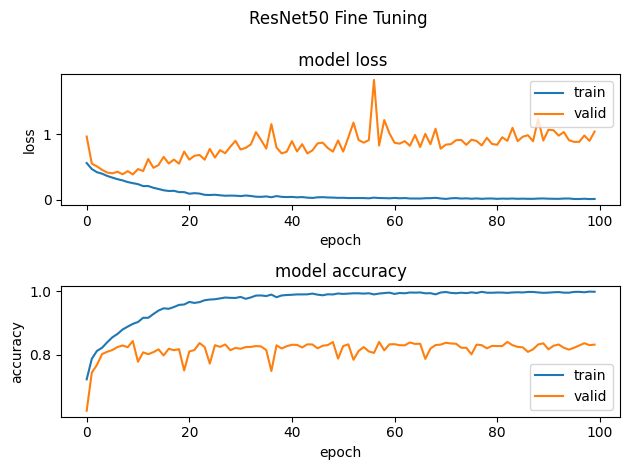

In [ ]:
get_plot_loss_acc(model_ft, f"ResNet50 Fine Tuning")

### **Test Accuracy**

Below, the test accuracy of the model is shown.

In [ ]:
get_evaluate(test_generator, "Test", model)

26/26 [==============================] - 4s 132ms/step - loss: 0.3393 - accuracy: 0.9371
Test loss: 0.339342
Test accuracy: 0.937122


### **Precision, Recall and F1-score**

Below, the precision, recall, and F1 score metrics for the model are shown.

In [ ]:
# Model predictions
y_pred_proba = get_predict(test_generator, model)
y_pred = np.argmax(y_pred_proba, axis=1)

26/26 [==============================] - 4s 98ms/step


In [ ]:
get_metrics(test_generator.labels, y_pred, "Test")

Accuracy Score - Test: 0.93
Balanced Accuracy Score - Test: 0.93


              precision    recall  f1-score   support

    Positive    0.93542   0.94526   0.94031       475
    Negative    0.92507   0.91193   0.91845       352

    accuracy                        0.93108       827
   macro avg    0.93024   0.92860   0.92938       827
weighted avg    0.93101   0.93108   0.93101       827



### **Confusion Matrix**


Below are the two confusion matrices, shown both as percentages and in absolute values.

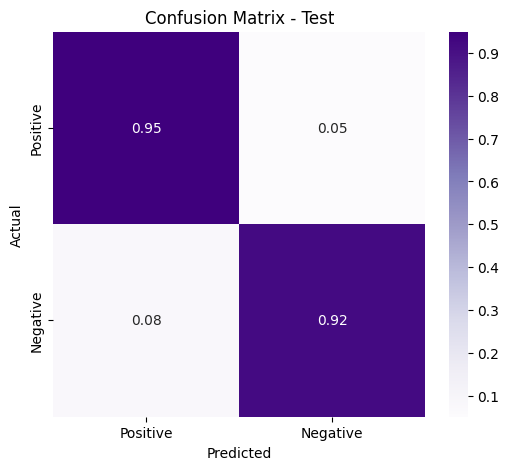

In [ ]:
compute_confusion_matrix(test_generator, y_pred_proba, ['Positive', 'Negative'], "Test")

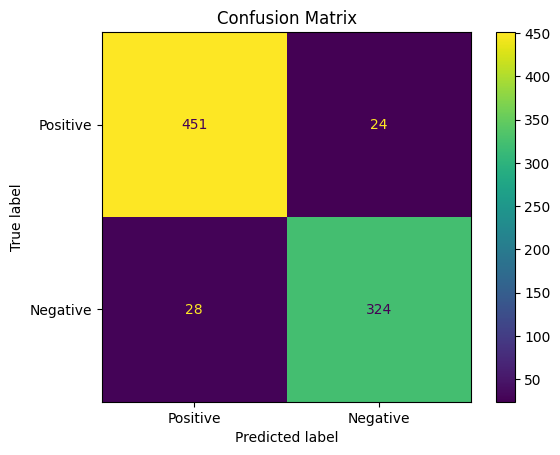

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(test_generator.labels, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Positive', 'Negative'])

# Display confusion matrix
cmd.plot()
plt.title('Confusion Matrix')
plt.show()

### **Grad-CAM**

Below, the Grad-CAM application on a test set image of the Positive class is shown.

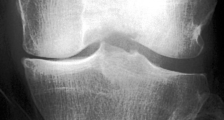

In [ ]:
from IPython.display import Image, display

img_size = (224, 224)

# Load ResNet50 preprocessing and decoding functions
preprocess_input = tf.keras.applications.resnet50.preprocess_input
decode_predictions = tf.keras.applications.resnet50.decode_predictions
last_conv_layer_name = "conv5_block3_out"

# Define the path to test images and select a random image
test_dir = "/content/KneeKL/test/Positive"
img_list = glob.glob(test_dir + "/*.png")
img_path = random.choice(img_list)

# Read and preprocess the image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
equalized_img = cv2.equalizeHist(img)

# Save the processed image and display it
cv2.imwrite(img_path, equalized_img)
display(Image(img_path))

1/1 [==============================] - 0s 23ms/step
Predicted: Positive with confidence 1.00


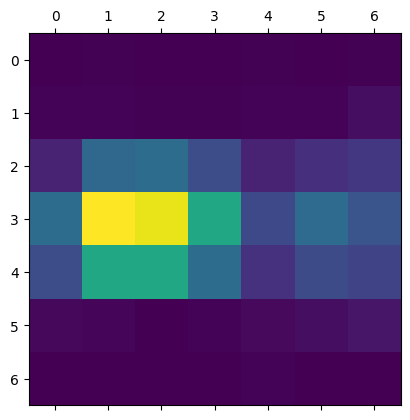

In [ ]:
# Preprocess the input image and make predictions
img_array = preprocess_input(get_img_array(img_path, size=img_size))
preds = model.predict(img_array)
class_labels = ['Negative', 'Positive']
predicted_class = class_labels[np.argmax(preds)]

# Display the predicted class and confidence
print(f"Predicted: {predicted_class} with confidence {np.max(preds):.2f}")

# Generate and display the Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

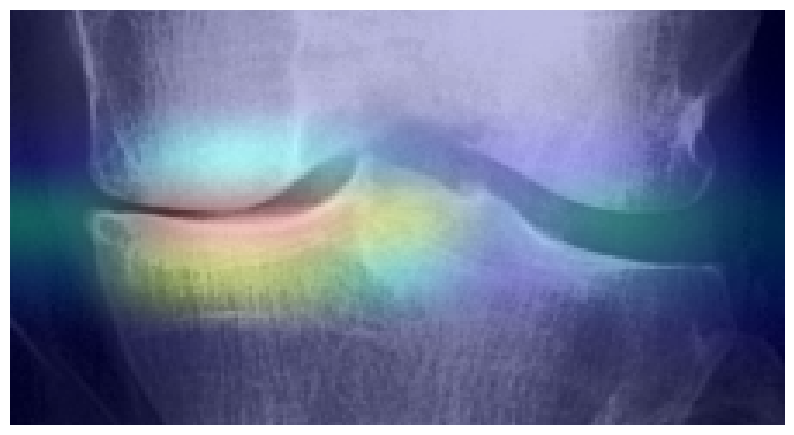

In [ ]:
save_and_display_gradcam(img_path, heatmap)